In [1]:
! pip install ipympl

In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from itertools import combinations 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

In [3]:
# get the train and test data from the input strings for the file locations
# ie train_data = "./data/Data1Train.csv"
def getData(train_data, test_data):
    X1_df = pd.read_csv(train_data)
    X1T_df = pd.read_csv(test_data)

    X1_train = X1_df[['x', 'y']]
    Y1_train = X1_df[['Class']]
    X1_test = X1T_df[['x', 'y']]
    Y1_test = X1T_df[['Class']]

    return X1_train, Y1_train, X1_test, Y1_test

In [22]:
# create class Node that stores its children, model used, and is it a leaf
class Node:
    def __init__(self, model):
        self.model = model
        self.isLeaf = True
        self.Left = None
        self.Right = None

    def setRight(self, node_in):
        self.Right = node_in
        self.isLeaf = False

    def setLeft(self, node_in):
        self.Left = node_in
        self.isLeaf = False

In [63]:
# using sklearn.svm to construct boundaries (to choose an optimtal boundary)
# calculate measure of purity (measure of how well stuff is clustered) sklearn metrics
# have flag for linear boundaries or rbf for SVC modeling
# this cell will be a function to create the tree from input data
from sklearn.tree import DecisionTreeClassifier

def gini_two(Y_actual, Y_pred):
    return 1 - np.sum((Y_actual - Y_pred)**2)


def separate_one(X_train, Y_train, is_not_linear, class_label_one):
    Y_bin = np.isin(Y_train, [class_label_one]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf')
    model.fit(X_train, Y_bin)
    return model

def evaluate_model_one(X_test, Y_test, model, class_label_one):
    Y_bin = (Y_test == class_label_one).astype(int)
    #Y_bin.ravel()
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_bin, Y_pred)
    return acc

def separate_two(X_train, Y_train, is_not_linear, class_label_one, class_label_two):
    Y_bin = np.isin(Y_train, [class_label_one, class_label_two]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf')
    model.fit(X_train, Y_bin)
    return model

def evaluate_model_two(X_test, Y_test, model, class_label_one, class_label_two):
    Y_bin = np.isin(Y_test, [class_label_one, class_label_two]).astype(int)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_bin, Y_pred)
    return acc


In [64]:
# run the tree build on training data 1 and use test for dataset 1
X_train, Y_train, X_test, Y_test = getData('./data/Data1Train.csv', './data/Data1Test.csv')

class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
best_model = None
best_acc = 0.0
best_class_one = 1
best_class_two = 1
for class_label_one, class_label_two in class_pairs:
    curr_model = separate_two(X_train, Y_train, False, class_label_one, class_label_two)
    curr_acc = evaluate_model_two(X_test, Y_test, curr_model, class_label_one, class_label_two)
    if curr_acc >= best_acc:
        best_acc = curr_acc
        best_class_one = class_label_one
        best_class_two = class_label_two
        best_model = curr_model
    print(str(class_label_one) + " and " + str(class_label_two) + " had accuracy of " + str(curr_acc))

root = Node(best_model)
#print(str(best_class_one) + " and " + str(best_class_two) + " had accuracy of " + str(best_acc))

# partition training data
part_1_indices = np.isin(Y_train, [1, 2])
part_2_indices = np.isin(Y_train, [3, 4])
part_1_indicesT = np.isin(Y_test, [1, 2])
part_2_indicesT = np.isin(Y_test, [3, 4])

X_train_part_1 = X_train[part_1_indices]
Y_train_part_1 = Y_train[part_1_indices]
X_test_part_1 = X_test[part_1_indicesT]
Y_test_part_1 = Y_test[part_1_indicesT]

X_train_part_2 = X_train[part_2_indices]
Y_train_part_2 = Y_train[part_2_indices]
X_test_part_2 = X_test[part_2_indicesT]
Y_test_part_2 = Y_test[part_2_indicesT] 

curr_model_1 = separate_one(X_train_part_1, Y_train_part_1, False, 1)
curr_acc_1 = evaluate_model_one(X_test_part_1, Y_test_part_1, curr_model_1, 1)
curr_right = Node(curr_model_1)
root.setRight(curr_right)
curr_right.setLeft(Node(1))
curr_right.setRight(Node(2))

curr_model_2 = separate_one(X_train_part_2, Y_train_part_2, False, 3)
curr_acc_2 = evaluate_model_one(X_test_part_2, Y_test_part_2, curr_model_2, 3)
curr_left = Node(curr_model_2)
root.setLeft(curr_left)
curr_left.setLeft(Node(3))
curr_left.setRight(Node(4))
#plt.scatter(X_train['x'], X_train['y'])
#plt.show()

1 and 2 had accuracy of 1.0
1 and 3 had accuracy of 1.0
1 and 4 had accuracy of 0.7402597402597403
2 and 3 had accuracy of 0.7402597402597403
2 and 4 had accuracy of 1.0
3 and 4 had accuracy of 1.0


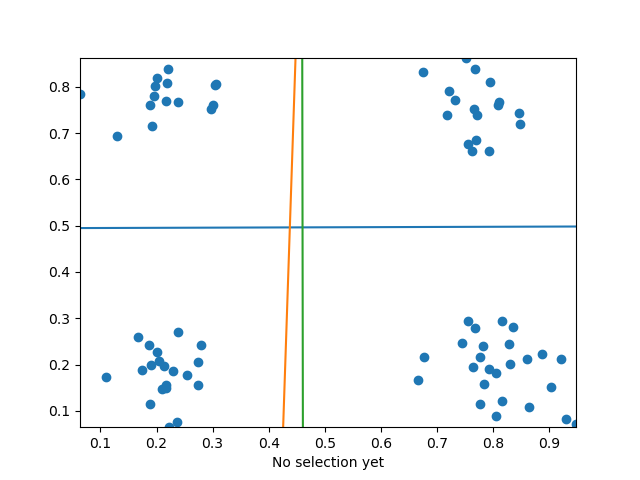

In [65]:
# interactive plot for data 1
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
minX1 = (-best_model.intercept_-best_model.coef_[0,0]*minX0D)/best_model.coef_[0,1]
maxX1 = (-best_model.intercept_-best_model.coef_[0,0]*maxX0D)/best_model.coef_[0,1]

minX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*minX0D)/curr_model_1.coef_[0,1]
maxX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*maxX0D)/curr_model_1.coef_[0,1]

minX3 = (-curr_model_2.intercept_-curr_model_2.coef_[0,0]*minX0D)/curr_model_2.coef_[0,1]
maxX3 = (-curr_model_2.intercept_-curr_model_2.coef_[0,0]*maxX0D)/curr_model_2.coef_[0,1]

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')
plt.plot([minX0D,maxX0D],[minX1,maxX1])
plt.plot([minX0D,maxX0D],[minX2,maxX2])
plt.plot([minX0D,maxX0D],[minX3,maxX3])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        if (-best_model.intercept_-best_model.coef_[0,0]*event.xdata)/best_model.coef_[0,1]<event.ydata:
            #tx = tx + ' Class 1 is selected'
            if event.xdata < (-curr_model_1.intercept_ + curr_model_1.coef_[0,1] * event.ydata) / curr_model_1.coef_[0,0]:
                tx = tx + ' Class 1 is selected'
            else:
                tx = tx + ' Class 2 is selected'
        else:
            #tx = tx + ' Class 2 is selected'
            if event.xdata < (-curr_model_2.intercept_ + curr_model_2.coef_[0,1] * event.ydata) / curr_model_2.coef_[0,0]:
                tx = tx + ' Class 3 is selected'
            else:
                tx = tx + ' Class 4 is selected'
        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')
        plt.plot([minX0D,maxX0D],[minX1,maxX1])
        plt.plot([minX0D,maxX0D],[minX2,maxX2])
        plt.plot([minX0D,maxX0D],[minX3,maxX3])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [66]:
# run the tree build on training data 2 and use test for dataset 2

X_train, Y_train, X_test, Y_test = getData('./data/Data2Train.csv', './data/Data2Test.csv')

class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
best_model = None
best_acc = 0.0
best_class_one = 1
best_class_two = 1
for class_label_one, class_label_two in class_pairs:
    curr_model = separate_two(X_train, Y_train, False, class_label_one, class_label_two)
    curr_acc = evaluate_model_two(X_test, Y_test, curr_model, class_label_one, class_label_two)
    if curr_acc >= best_acc:
        best_acc = curr_acc
        best_class_one = class_label_one
        best_class_two = class_label_two
        best_model = curr_model
    print(str(class_label_one) + " and " + str(class_label_two) + " had accuracy of " + str(curr_acc))

root = Node(best_model)
#print(str(best_class_one) + " and " + str(best_class_two) + " had accuracy of " + str(best_acc))

# partition training data
part_1_indices = np.isin(Y_train, [1, 2])
part_2_indices = np.isin(Y_train, [3, 4])
part_1_indicesT = np.isin(Y_test, [1, 2])
part_2_indicesT = np.isin(Y_test, [3, 4])

X_train_part_1 = X_train[part_1_indices]
Y_train_part_1 = Y_train[part_1_indices]
X_test_part_1 = X_test[part_1_indicesT]
Y_test_part_1 = Y_test[part_1_indicesT]

X_train_part_2 = X_train[part_2_indices]
Y_train_part_2 = Y_train[part_2_indices]
X_test_part_2 = X_test[part_2_indicesT]
Y_test_part_2 = Y_test[part_2_indicesT] 

curr_model_1 = separate_one(X_train_part_1, Y_train_part_1, False, 1)
curr_acc_1 = evaluate_model_one(X_test_part_1, Y_test_part_1, curr_model_1, 1)
curr_right = Node(curr_model_1)
root.setRight(curr_right)
curr_right.setLeft(Node(1))
curr_right.setRight(Node(2))

curr_model_2 = separate_one(X_train_part_2, Y_train_part_2, False, 3)
curr_acc_2 = evaluate_model_one(X_test_part_2, Y_test_part_2, curr_model_2, 3)
curr_left = Node(curr_model_2)
root.setLeft(curr_left)
curr_left.setLeft(Node(3))
curr_left.setRight(Node(4))
#plt.scatter(X_train['x'], X_train['y'])
#plt.show()

1 and 2 had accuracy of 1.0
1 and 3 had accuracy of 1.0
1 and 4 had accuracy of 0.73
2 and 3 had accuracy of 0.73
2 and 4 had accuracy of 1.0
3 and 4 had accuracy of 1.0


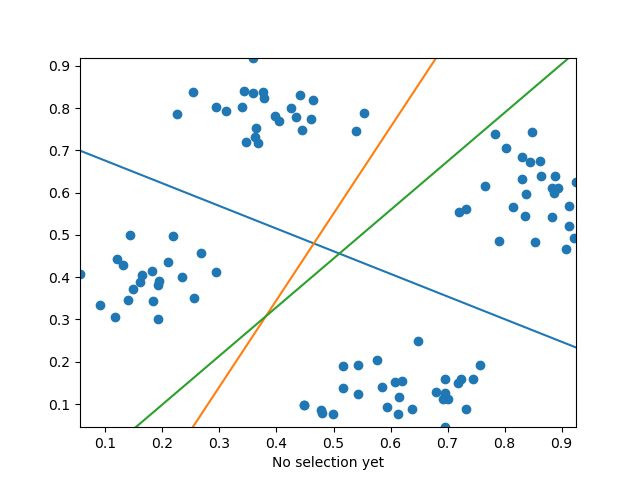

In [67]:
# interactive plot for data 2
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
minX1 = (-best_model.intercept_-best_model.coef_[0,0]*minX0D)/best_model.coef_[0,1]
maxX1 = (-best_model.intercept_-best_model.coef_[0,0]*maxX0D)/best_model.coef_[0,1]

minX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*minX0D)/curr_model_1.coef_[0,1]
maxX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*maxX0D)/curr_model_1.coef_[0,1]

minX3 = (-curr_model_2.intercept_-curr_model_2.coef_[0,0]*minX0D)/curr_model_2.coef_[0,1]
maxX3 = (-curr_model_2.intercept_-curr_model_2.coef_[0,0]*maxX0D)/curr_model_2.coef_[0,1]

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')
plt.plot([minX0D,maxX0D],[minX1,maxX1])
plt.plot([minX0D,maxX0D],[minX2,maxX2])
plt.plot([minX0D,maxX0D],[minX3,maxX3])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        if (-best_model.intercept_-best_model.coef_[0,0]*event.xdata)/best_model.coef_[0,1]<event.ydata:
            #tx = tx + ' Class 1 is selected'
            if event.xdata < (-curr_model_1.intercept_ + curr_model_1.coef_[0,1] * event.ydata) / curr_model_1.coef_[0,0]:
                tx = tx + ' Class 1 is selected'
            else:
                tx = tx + ' Class 2 is selected'
        else:
            #tx = tx + ' Class 2 is selected'
            if event.xdata < (-curr_model_2.intercept_ + curr_model_2.coef_[0,1] * event.ydata) / curr_model_2.coef_[0,0]:
                tx = tx + ' Class 3 is selected'
            else:
                tx = tx + ' Class 4 is selected'
        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')
        plt.plot([minX0D,maxX0D],[minX1,maxX1])
        plt.plot([minX0D,maxX0D],[minX2,maxX2])
        plt.plot([minX0D,maxX0D],[minX3,maxX3])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [70]:
# run the tree build on training data 3 and use test for dataset 3

X_train, Y_train, X_test, Y_test = getData('./data/Data3Train.csv', './data/Data3Test.csv')

class_pairs = [(1, 2), (1, 3), (2,3)]
best_model = None
best_acc = 0.0
best_class_one = 1
best_class_two = 1
for class_label_one, class_label_two in class_pairs:
    curr_model = separate_two(X_train, Y_train, False, class_label_one, class_label_two)
    curr_acc = evaluate_model_two(X_test, Y_test, curr_model, class_label_one, class_label_two)
    if curr_acc >= best_acc:
        best_acc = curr_acc
        best_class_one = class_label_one
        best_class_two = class_label_two
        best_model = curr_model
    print(str(class_label_one) + " and " + str(class_label_two) + " had accuracy of " + str(curr_acc))

root = Node(best_model)
#print(str(best_class_one) + " and " + str(best_class_two) + " had accuracy of " + str(best_acc))

# partition training data
part_1_indices = np.isin(Y_train, [2, 3])
part_1_indicesT = np.isin(Y_test, [1, 2])

X_train_part_1 = X_train[part_1_indices]
Y_train_part_1 = Y_train[part_1_indices]
X_test_part_1 = X_test[part_1_indicesT]
Y_test_part_1 = Y_test[part_1_indicesT]

curr_model_1 = separate_one(X_train_part_1, Y_train_part_1, False, 2)
curr_acc_1 = evaluate_model_one(X_test_part_1, Y_test_part_1, curr_model_1, 2)
curr_right = Node(curr_model_1)
root.setRight(curr_right)
curr_right.setLeft(Node(3))
curr_right.setRight(Node(2))

root.setLeft(Node(1))
#plt.scatter(X_train['x'], X_train['y'])
#plt.show()

1 and 2 had accuracy of 0.8666666666666667
1 and 3 had accuracy of 0.85
2 and 3 had accuracy of 0.8666666666666667


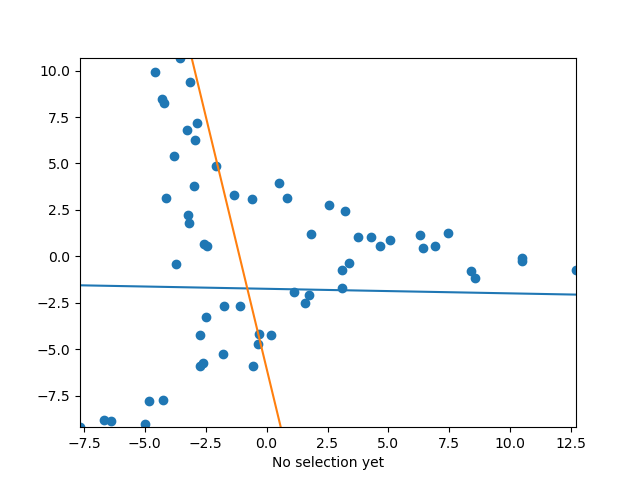

In [72]:
# interactive plot for data 3
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()
minX1 = (-best_model.intercept_-best_model.coef_[0,0]*minX0D)/best_model.coef_[0,1]
maxX1 = (-best_model.intercept_-best_model.coef_[0,0]*maxX0D)/best_model.coef_[0,1]

minX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*minX0D)/curr_model_1.coef_[0,1]
maxX2 = (-curr_model_1.intercept_-curr_model_1.coef_[0,0]*maxX0D)/curr_model_1.coef_[0,1]

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')
plt.plot([minX0D,maxX0D],[minX1,maxX1])
plt.plot([minX0D,maxX0D],[minX2,maxX2])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

# change on click if/else statements to recurse through tree with input x
# and y point. Go left if under 1st boundary and right if above. Continue until
# a leaf is reached and then return the class of the leaf

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        if (-best_model.intercept_-best_model.coef_[0,0]*event.xdata)/best_model.coef_[0,1]<event.ydata:
            #tx = tx + ' Class 1 is selected'
            if event.xdata < (-curr_model_1.intercept_ + curr_model_1.coef_[0,1] * event.ydata) / curr_model_1.coef_[0,0]:
                tx = tx + ' Class 2 is selected'
            else:
                tx = tx + ' Class 3 is selected'
        else:
            tx = tx + ' Class 1 is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')
        plt.plot([minX0D,maxX0D],[minX1,maxX1])
        plt.plot([minX0D,maxX0D],[minX2,maxX2])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
# run the tree build on training data 4 and use test for dataset 4

In [2]:
%matplotlib widget